In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 11
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((516, 12, 1), (516,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT11/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 214ms/step - loss: 0.2919 - root_mean_squared_error: 0.5402 - val_loss: 0.1297 - val_root_mean_squared_error: 0.3602
Epoch 2/50
53/53 [==============================] - 10s 189ms/step - loss: 0.1553 - root_mean_squared_error: 0.3941 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1785
Epoch 3/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1801
Epoch 4/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0489 - root_mean_squared_error: 0.2211 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1749
Epoch 5/50
53/53 [==============================] - 1s 28ms/step - loss: 0.0471 - root_mean_squared_error: 0.2171 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1769
Epoch 6/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.0357 - val_

Epoch 41/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1485
Epoch 42/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0198 - root_mean_squared_error: 0.1409 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1379
Epoch 43/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1461
Epoch 44/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1567
Epoch 45/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 46/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0200 - root_mean_squared_error: 0.1416 - val_loss: 0.0238 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

2.813883133729299 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

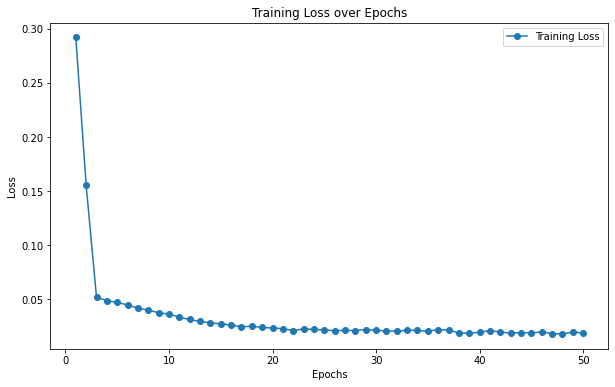

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

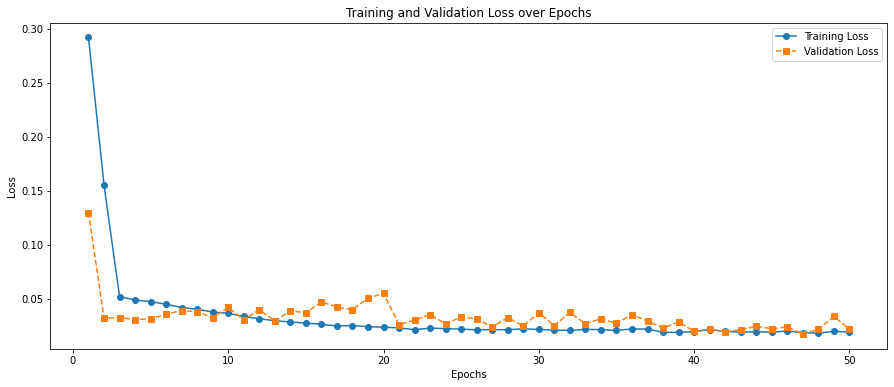

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT11/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.11607462737439292
MAE : 0.08800896688633995


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,689476.06250,734946.437
1,703737.75000,777596.225
2,706398.12500,687087.673
3,675538.31250,622337.816
4,579159.87500,467232.074
5,465252.71875,297495.641
6,414821.18750,268909.854
7,434793.43750,408072.791
8,457765.31250,552314.148
9,506312.53125,651062.408


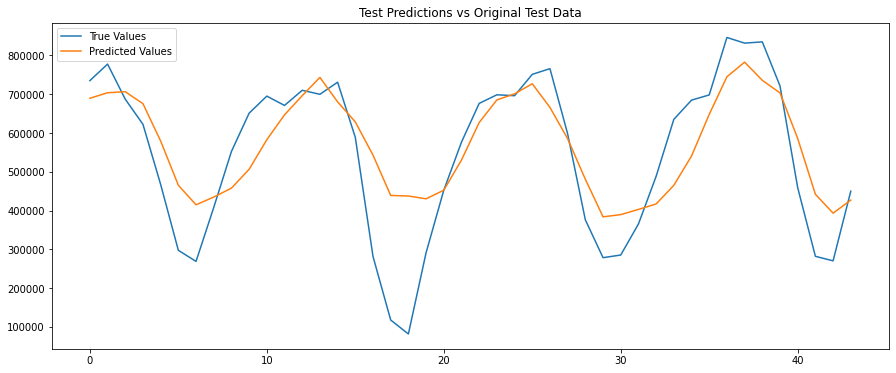

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

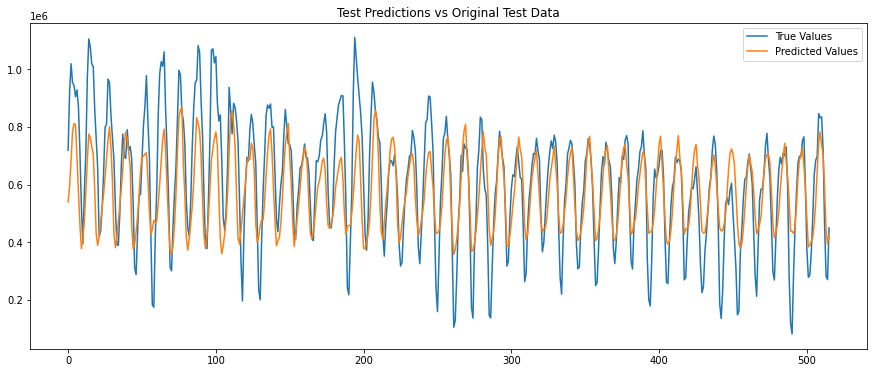

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()